In [1]:
# This routine can calculate El Nino Southern Oscillation index and pattern
# It uses Empirical orthogonal functions of yearly SST data to do so.
# Many researchers consider a method following Nino34 to be supperior: 
# https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from tqdm import tqdm
from eofs.standard import Eof
from eofs.examples import example_data_path
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.fft import fft, fftfreq
import matplotlib.tri as mtri
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import matplotlib.pylab as plt
from matplotlib.cm import ScalarMappable
from scipy import signal

%matplotlib inline


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
abg = [0, 0, 0]
variable = 'sst'
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/fesom/']
years = range(2350, 2430)
figsize=(10, 5)
dpi = 200
ofile = None

In [3]:
# load mesh and data
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

data_raw = pf.get_data(input_paths[0], 'sst', years, mesh, how=None, compute=False, silent=True)

model_lon = mesh.x2
model_lon = np.where(model_lon < 0, model_lon+360, model_lon)
model_lat = mesh.y2

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [4]:
# TODO better to detrend and use monthly?
data = []
steps_per_year=int(np.shape(data_raw)[0]/len(years))
for y in tqdm(range(len(years))):
    data.append(np.mean(data_raw[y*steps_per_year:y*steps_per_year+steps_per_year-1,:],axis=0))
data = np.asarray(data)
data = signal.detrend(data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 812.58it/s]


In [5]:
# Detrend linearly to remove forcing or spinup induced trends
# TODO: probably better to detrend with something like a 50 year running mean
data_raw = signal.detrend(data_raw)

# Reshape to add monthly time axis
data_raw_reshape = data_raw.reshape(data_raw.shape[0]//12,data_raw.shape[1], 12)

# Calculate seasonal cycle
data_season_cycle = np.mean(data_raw_reshape,axis=0)

# Repeat seasonal cycle
data_season_cycle_repeat = np.repeat(data_season_cycle[np.newaxis,...],np.shape(data_raw_reshape)[0],axis=0)

# Reshape into original format
data_season_cycle_repeat_reshape = data_season_cycle_repeat.reshape(np.shape(data_raw))

# Remove seasonal cycle from data
data = data_raw - data_season_cycle_repeat_reshape

In [6]:
#select ENSO region
lon = np.linspace(110, 290, 181)
lat = np.linspace(-45, 45, 60)
lon2, lat2 = np.meshgrid(lon, lat)

In [7]:
# interpolate data onto regular grid
sst = []
points = np.vstack((model_lon, model_lat)).T
for t in tqdm(range(0, np.shape(data)[0])):
    nn_interpolation = NearestNDInterpolator(points, data[t,:])
    sst.append(nn_interpolation((lon2, lat2)))
sst=np.asarray(sst)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [00:45<00:00, 21.11it/s]


In [19]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1_corr = solver.eofsAsCorrelation(neofs=1)
eof1 = solver.eofs(neofs=1, eofscaling=2)
eof_abs = solver.eofs(neofs=1)
pc1 = -np.squeeze(solver.pcs(npcs=1, pcscaling=1))



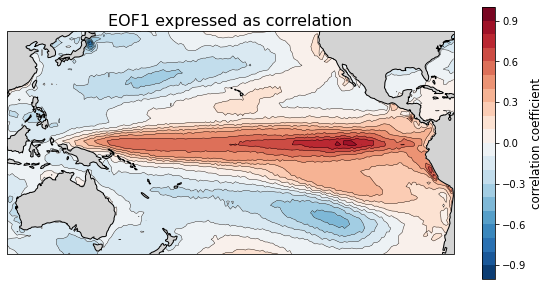

In [20]:
# Sign of correlation is arbitrary, but plot should be positive
if np.mean(eof1_corr) < 0:
    eof1_corr = -eof1_corr
if np.mean(eof1) < 0:
    eof1 = -eof1

# Plot the leading EOF in the Pacific domain.
plt.figure(figsize=figsize)
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = ax.contourf(lon2, lat2, eof1.squeeze(), clevs,
                   transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,zorder=-1)
line_colors = ['black' for l in fill.levels]
con = ax.contour(lon2, lat2, eof1.squeeze(), clevs, colors=line_colors, linewidths=0.4,
                   transform=ccrs.PlateCarree(),zorder=-1)
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.COASTLINE)

cb = plt.colorbar(fill, orientation='vertical')
cb.set_label('correlation coefficient', fontsize=12)
plt.title('EOF1 expressed as correlation', fontsize=16)

if ofile is not None:
    ofile_long = f"{ofile}_enso_eof.png"
    plt.savefig(f"{ofile_long}", dpi=dpi)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')



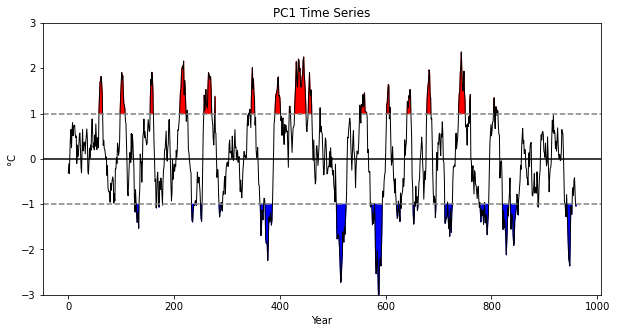

In [25]:
# Plot the leading PC time series.
plt.figure(figsize=figsize)
plt.plot(pc1, color='black', linewidth=1) 
plt.axhline(0, color='k')
plt.title('PC1 Time Series')
plt.xlabel('Year')
plt.ylabel('°C')
plt.ylim(-3, 3)
plt.axhline(y=1, color='grey', linestyle='--')
plt.axhline(y=-1, color='grey', linestyle='--')
#plt.axvline(x=2350, color='black', linestyle='-')

months = np.arange(len(pc1))

plt.fill_between(months, pc1, 1, where = (pc1 > 1), color='red')
plt.fill_between(months, pc1, -1, where = (pc1 < -1), color='blue')




if ofile is not None:
    ofile_long = f"{ofile}_enso_pc1.png"
    plt.savefig(f"{ofile_long}", dpi=dpi)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

Text(0.5, 0, 'PC1 Frequency')

<Figure size 720x360 with 0 Axes>

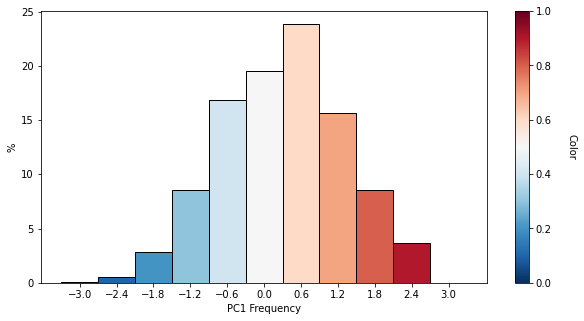

In [11]:
# bar plot of frequency 
plt.figure(figsize=figsize)
nbins=11
bins = np.linspace(-3, 3, nbins)
digitized = np.digitize(pc1, bins)

freq=[]
for i in range(nbins):
    freq.append(list(digitized).count(i))
freq=np.asarray(freq)
freq=freq/len(digitized)

data_x = bins
data_hight = freq*100
data_color = bins+3

data_color = [x / max(data_color) for x in data_color]
fig, ax = plt.subplots(figsize=(10, 5))

my_cmap = plt.cm.get_cmap('RdBu_r')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight,width=0.6, color=colors,edgecolor='black')

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(min(data_color),max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Color', rotation=270,labelpad=25)

plt.xticks(data_x)    
plt.ylabel("%")
plt.xlabel("PC1 Frequency")


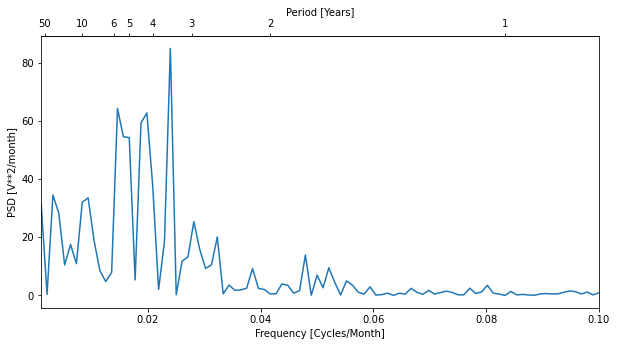

In [14]:
f, Pxx_den = signal.periodogram(pc1)

fig, ax = plt.subplots(figsize=figsize)

ax.plot(f,Pxx_den)
ax.set_xlim([0.001, 0.1])
plt.xlabel('Frequency [Cycles/Month]')
plt.ylabel('PSD [V**2/month]')

def twelve_over(x):
    """Vectorized 12/x, treating x==0 manually"""
    x = np.array(x*12).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

# the function "12/x" is its own inverse
inverse = twelve_over

secax = ax.secondary_xaxis('top', functions=(twelve_over, inverse))
secax.set_xlabel('Period [Years]')
secax.set_xticks([50,10,6,5,4,3,2,1])

if ofile is not None:
    ofile_long = f"{ofile}_enso_pc1_freq.png"
    plt.savefig(f"{ofile_long}", dpi=dpi)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')
